In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime, timedelta
from fredapi import Fred
import quandl

In [3]:
def get_info(names):
    data = []
    for i in range(len(names)):
        data.append(fred.get_series(names[i]).to_frame().rename(columns={0:names[i]}))
        data[i] = data[i].groupby(data[i].index.year).mean().dropna()
    return data

In [4]:
# https://github.com/mortada/fredapi
fred = Fred(api_key="a02df0a22c57860f5f7cf25edc70ffb3")
quandl.ApiConfig.api_key = "QZLZXdHDDPZna9Yw48NP"

# Midwest - Ohio

Define the variables to be used in analysis:

X attributes:

 - *Monthly* Stocks
     - S&P 500 (MULTPL/SP500_REAL_PRICE_MONTH)
 - *Quarterly* GDP (GDP)
 - *Annual* Unemployment Rate (LAUST390000000000003A)
 - *Annual* House Ownership Ratio (OHHOWN)
 - *Annual* Resident Population (OHPOP)
 - *Annual* Median Income Rate (MEHOINUSOHA672N)
 - *Annual* Home Vacancy Rate (OHHVAC)

y attributes:

 - *Quarterly* Ohio State Housing Price Index (OHSTHPI)

Connect to APIs and create a dataframe with information on each dataset:

In [5]:
sp500 = quandl.get('MULTPL/SP500_REAL_PRICE_MONTH').rename(columns={'Value':'SP500'})
sp500 = sp500.groupby(sp500.index.year).mean().dropna()
names_oh = ['LAUST390000000000003A', "OHHOWN","OHPOP", "MEHOINUSOHA672N", "OHHVAC", "GDP"]
oh_data_series = get_info(names_oh) + [sp500]

In [6]:
# quarterly housing price index
ohHPI = fred.get_series('OHSTHPI').to_frame()
ohHPI.index.name = "DATE"
ohHPI = ohHPI.rename(columns={0:"OHSTHPI"})
# convert to annual
ohHPI_annual = ohHPI.groupby(ohHPI.index.year).mean()

In [7]:
oh_annual = ohHPI_annual.copy()
for df in oh_data_series:
    oh_annual = oh_annual.merge(df, left_index=True, right_index=True)
oh_annual.tail()

,OHSTHPI,LAUST390000000000003A,OHHOWN,OHPOP,MEHOINUSOHA672N,OHHVAC,GDP,SP500
2014,241.2700,5.8,67.3,11602.973,52708.0,1.6,17527.25825,1930.667500
2015,250.8625,4.9,66.4,11617.850,56494.0,1.8,18224.78025,2061.199167
2016,261.2600,5.0,66.1,11635.003,56490.0,1.5,18715.04050,2091.844167
2017,274.8250,5.0,66.0,11664.129,62167.0,1.4,19519.42350,2448.217500
2018,291.9225,4.6,67.3,11689.442,61633.0,1.1,20580.22300,2744.680000


In [ ]:
Analyze the correlation coefficient for each indicator we have specified:

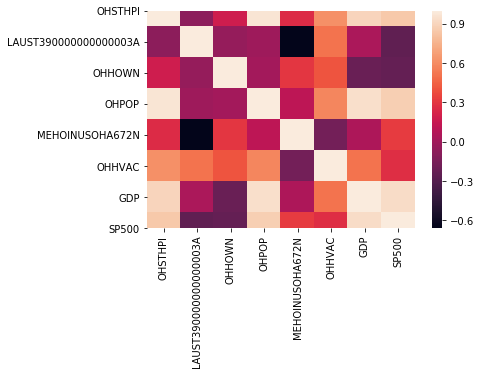

In [8]:
corr = oh_annual.corr().round(4)
sns.heatmap(data=corr)

In [9]:
corr

,OHSTHPI,LAUST390000000000003A,OHHOWN,OHPOP,MEHOINUSOHA672N,OHHVAC,GDP,SP500
OHSTHPI,1.0000,-0.0742,0.1842,0.9685,0.2553,0.6238,0.9003,0.8491
LAUST390000000000003A,-0.0742,1.0000,-0.0379,-0.0087,-0.6591,0.5090,0.0432,-0.2486
OHHOWN,0.1842,-0.0379,1.0000,0.0100,0.3062,0.4048,-0.2085,-0.2276
OHPOP,0.9685,-0.0087,0.0100,1.0000,0.1139,0.5793,0.9460,0.8743
MEHOINUSOHA672N,0.2553,-0.6591,0.3062,0.1139,1.0000,-0.1700,0.0536,0.3208
OHHVAC,0.6238,0.5090,0.4048,0.5793,-0.1700,1.0000,0.5127,0.2704
GDP,0.9003,0.0432,-0.2085,0.9460,0.0536,0.5127,1.0000,0.9316
SP500,0.8491,-0.2486,-0.2276,0.8743,0.3208,0.2704,0.9316,1.0000


Create a model using linear regression to express the Housing Price Index as dependent on the other datasets we have downloaded:

In [10]:
X = oh_annual.drop(columns=['OHSTHPI'], axis=1)
Y = oh_annual['OHSTHPI']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R-Squared score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R-Squared score is {}'.format(r2))

The model performance for training set
--------------------------------------
Root Mean Squared Error is 5.797686770566625
R-Squared score is 0.9867195090934263


The model performance for testing set
--------------------------------------
Root Mean Squared Error is 5.249607745741014
R-Squared score is 0.9871061552359773
